In [78]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

tf.__version__

'2.20.0'

# Transferência de aprendizagem e fine tuning

## Carregamento da base de dados

In [ ]:
tf.keras.preprocessing.image.load_img('./homer_bart_2/training_set/bart/bart100.bmp')

In [ ]:
tf.keras.preprocessing.image.load_img('./homer_bart_2/training_set/homer/homer100.bmp')

## Base de dados de treinamento e teste

In [94]:
gerador_treinamento = ImageDataGenerator(rescale=1. / 255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('./homer_bart_2/training_set',
                                                              target_size=(256, 256),
                                                              batch_size=8,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 215 images belonging to 2 classes.


In [ ]:
dataset_treinamento.classes

In [ ]:
dataset_treinamento.class_indices

In [ ]:
gerador_teste = ImageDataGenerator(rescale=1. / 255)
dataset_teste = gerador_teste.flow_from_directory('./homer_bart_2/test_set',
                                                  target_size=(256, 256),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

## Rede neural pré-treinada

- ResNet: https://arxiv.org/pdf/1512.03385.pdf
- Documentação: https://keras.io/api/applications/

In [ ]:
modelo_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                             input_tensor=Input(shape=(256, 256, 3)))

In [ ]:
modelo_base.summary()

In [ ]:
len(modelo_base.layers)

In [ ]:
for layer in modelo_base.layers:
    layer.trainable = False

In [ ]:
for layer in modelo_base.layers:
    if layer.trainable:
        print(layer, layer.trainable)

## Camada densa personalizada

In [ ]:
modelo_base.output

In [ ]:
(2048 + 2) / 2

# 2048 -> Número de neuronios
# 2 -> Número de saídas


In [ ]:
(1025 * 20) / 100

In [ ]:
# 2048 -> 1025 -> 1025
head_model = modelo_base.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate=0.2)(head_model)
head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate=0.2)(head_model)
head_model = Dense(units=2, activation='softmax')(head_model)

## Construção e treinamento da rede neural

In [ ]:
modelo_base.input

In [ ]:
network = Model(inputs=modelo_base.input, outputs=head_model)

In [ ]:
network.summary()

In [ ]:
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historico = network.fit(dataset_treinamento, epochs=50, verbose=1)

## Avaliação da rede neural

In [ ]:
dataset_teste.class_indices

In [ ]:
previsoes = network.predict(dataset_teste)

In [ ]:
previsoes

In [ ]:
previsoes = np.argmax(previsoes, axis=1)
previsoes

In [ ]:
dataset_teste.classes

In [ ]:
accuracy_score(dataset_teste.classes, previsoes)

In [ ]:
cm = confusion_matrix(dataset_teste.classes, previsoes)
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(dataset_teste.classes, previsoes))

## Salvar e carregar a rede neural

In [ ]:
network.save('network.keras')

In [ ]:
network_loaded = tf.keras.models.load_model('network.keras')
network_loaded.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
network_loaded.summary()

## Fine tuning

In [ ]:
modelo_base.trainable = True
for layer in modelo_base.layers:
    layer.trainable = True

In [ ]:
for layer in modelo_base.layers:
    print(layer, layer.trainable)

In [ ]:
len(modelo_base.layers)

In [ ]:
fine_tuning_at = 140

In [ ]:
for layer in modelo_base.layers[:fine_tuning_at]:
    layer.trainable = False

In [ ]:
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historico = network.fit(dataset_treinamento, epochs=50, verbose=0)
historico

## Fining tuning - avaliação

In [ ]:
dataset_teste.class_indices

In [67]:
previsoes = network.predict(dataset_teste)

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [68]:
previsoes

array([[9.99963284e-01, 3.67383436e-05],
       [9.94659245e-01, 5.34079410e-03],
       [5.51625526e-05, 9.99944806e-01],
       [9.99999881e-01, 1.30890996e-07],
       [9.93420422e-01, 6.57961518e-03],
       [9.99875903e-01, 1.24109676e-04],
       [2.26890296e-03, 9.97731149e-01],
       [7.84500241e-01, 2.15499744e-01],
       [9.81092870e-01, 1.89071540e-02],
       [8.38067651e-01, 1.61932379e-01],
       [2.81881628e-04, 9.99718130e-01],
       [9.90848541e-01, 9.15146992e-03],
       [9.99995112e-01, 4.88653131e-06],
       [9.78139877e-01, 2.18600798e-02],
       [1.14603944e-01, 8.85396063e-01],
       [9.49668944e-01, 5.03310859e-02],
       [9.99555051e-01, 4.44988022e-04],
       [9.91898298e-01, 8.10168870e-03],
       [9.99949098e-01, 5.08737648e-05],
       [9.99999523e-01, 4.53755348e-07],
       [9.19917773e-04, 9.99080062e-01],
       [9.95277882e-01, 4.72216401e-03],
       [9.98992860e-01, 1.00716169e-03],
       [3.32853466e-01, 6.67146564e-01],
       [9.999970

In [72]:
previsoes = np.argmax(previsoes, axis=1)
previsoes

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [69]:
dataset_teste.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [73]:
accuracy_score(dataset_teste.classes, previsoes)

0.8888888888888888

<Axes: >

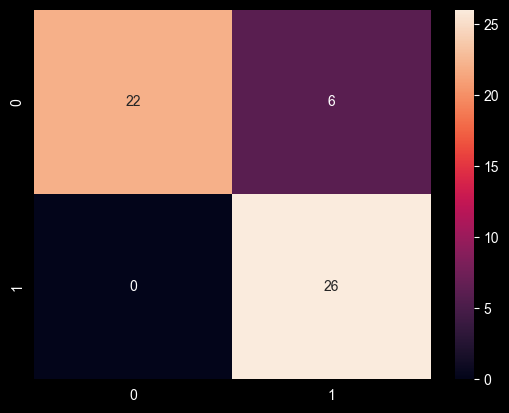

In [74]:
cm = confusion_matrix(dataset_teste.classes, previsoes)
sns.heatmap(cm, annot=True)

In [75]:
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        28
           1       0.81      1.00      0.90        26

    accuracy                           0.89        54
   macro avg       0.91      0.89      0.89        54
weighted avg       0.91      0.89      0.89        54



## Salvar e carregar a rede neural fine tuning

In [76]:
network.save('network-finetuning.keras')

In [ ]:
network_loaded = tf.keras.models.load_model('network-finetuning.keras')
network_loaded.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
network_loaded.summary()

## Classificação de uma única imagem

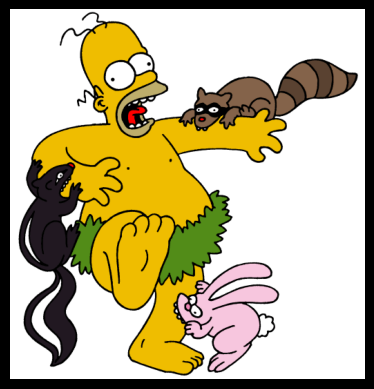

In [79]:
imagem = cv2.imread('./homer_bart_2/test_set/homer/homer15.bmp')
plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [80]:
imagem.shape

(536, 514, 3)

In [83]:
imagem = cv2.resize(imagem, (256, 256))

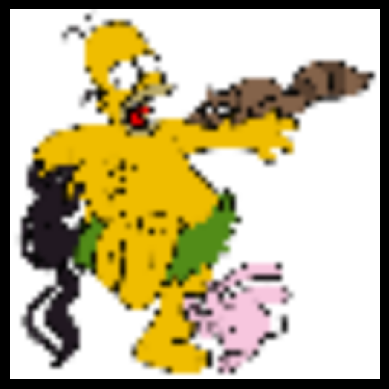

In [84]:
plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [85]:
imagem

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [86]:
imagem = imagem / 255

In [87]:
imagem.shape

(256, 256, 3)

In [89]:
imagem = imagem.reshape(-1, 256, 256, 3)
imagem.shape

(1, 256, 256, 3)

In [90]:
previsao = network_loaded.predict(imagem)
previsao

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.25349945, 0.7465006 ]], dtype=float32)

In [91]:
previsao = np.argmax(previsao)
previsao

np.int64(1)

In [92]:
dataset_teste.class_indices

{'bart': 0, 'homer': 1}

In [93]:
if previsao == 0:
    print('Bart')
else:
    print('Homer')

Homer
